# Brain Tumor Detection - ResNet50

## ResNet50 Architecture

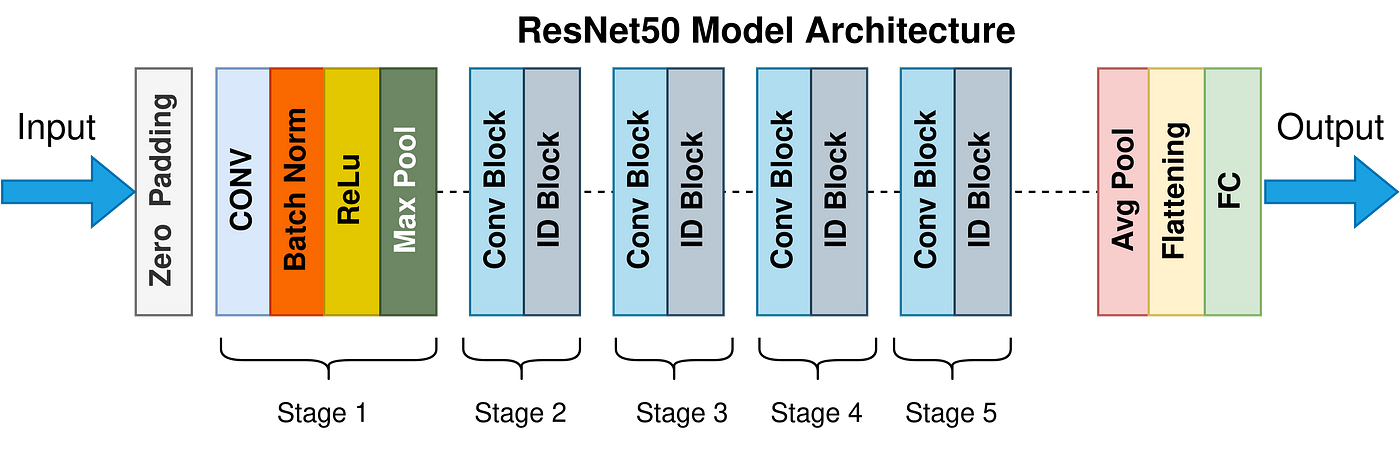

## Import Essential Libraries

In [48]:
# Regular Libraries Imports
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
import tensorflow as tf
import keras_tuner as kt
import os
import random

# Machine Learning Imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Define Constant image size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# 1. Data Exploration

In [49]:
glioma_images = os.listdir(DATASET_FOLDER + "/glioma")
meningioma_images = os.listdir(DATASET_FOLDER + "/meningioma")
no_tumor_images = os.listdir(DATASET_FOLDER + "/notumor")
pituitary_images = os.listdir(DATASET_FOLDER + "/pituitary")

# Check number of images in each category
print(f"Number of images in each category: Glioma: {len(glioma_images)}, Meningioma: {len(meningioma_images)}, No Tumor: {len(no_tumor_images)}, Pituitary: {len(pituitary_images)}")

Number of images in each category: Glioma: 120, Meningioma: 120, No Tumor: 120, Pituitary: 120


*Since there are equal number of data in each class, we can confirm that there will not be any class dominance.*

## Data Sample from each classes

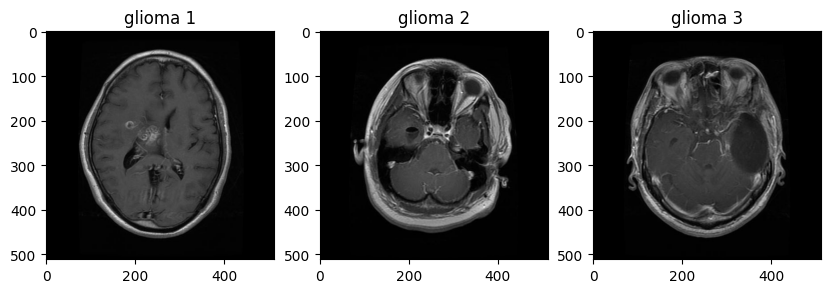

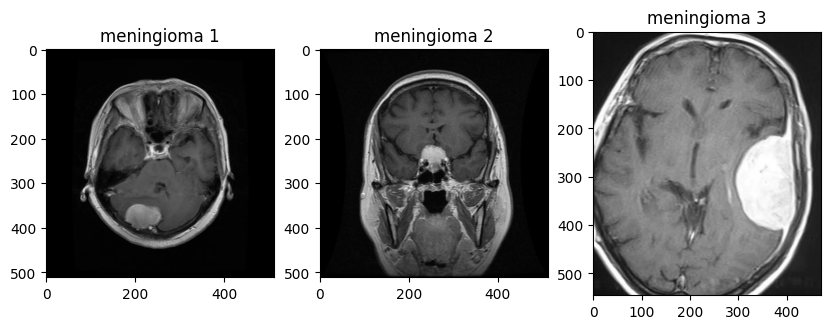

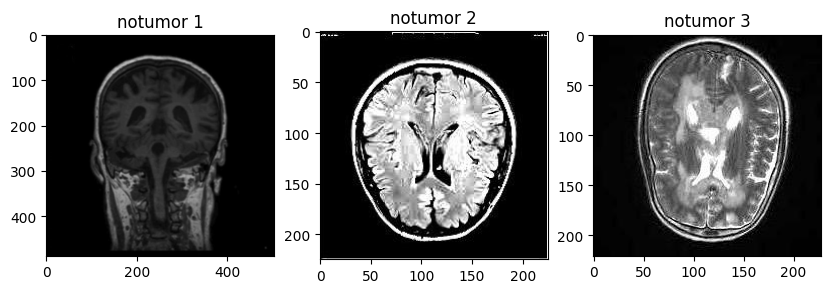

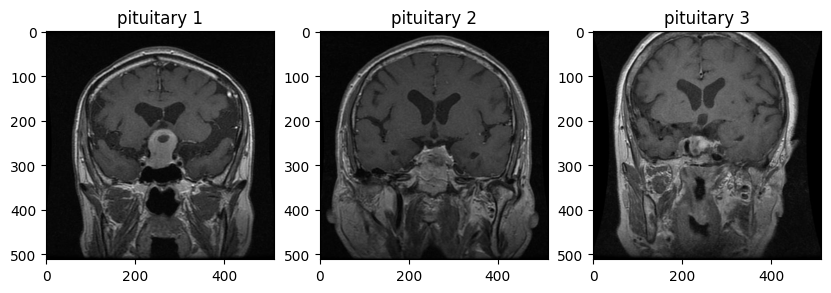

In [50]:
# Function to sample and plot images
def sample_and_plot_images(image_list, category_name, dataset_folder, n=3):
    sampled_images = random.sample(image_list, n)
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(dataset_folder, category_name, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category_name} {i+1}")
    plt.show()

# Sample and plot images for each category
sample_and_plot_images(glioma_images, "glioma", DATASET_FOLDER)
sample_and_plot_images(meningioma_images, "meningioma", DATASET_FOLDER)
sample_and_plot_images(no_tumor_images, "notumor", DATASET_FOLDER)
sample_and_plot_images(pituitary_images, "pituitary", DATASET_FOLDER)

*Based on the output of the sample images, the scale of each image are in differnet scale. Therefore, rescaling operation has to be done because it standardizes the range of pixel values, making the training process more stable and helping the model converge faster.*

# 2. Data Preparation

Found 336 images belonging to 4 classes.
Found 144 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Number of training images: 336
Number of validation images: 144


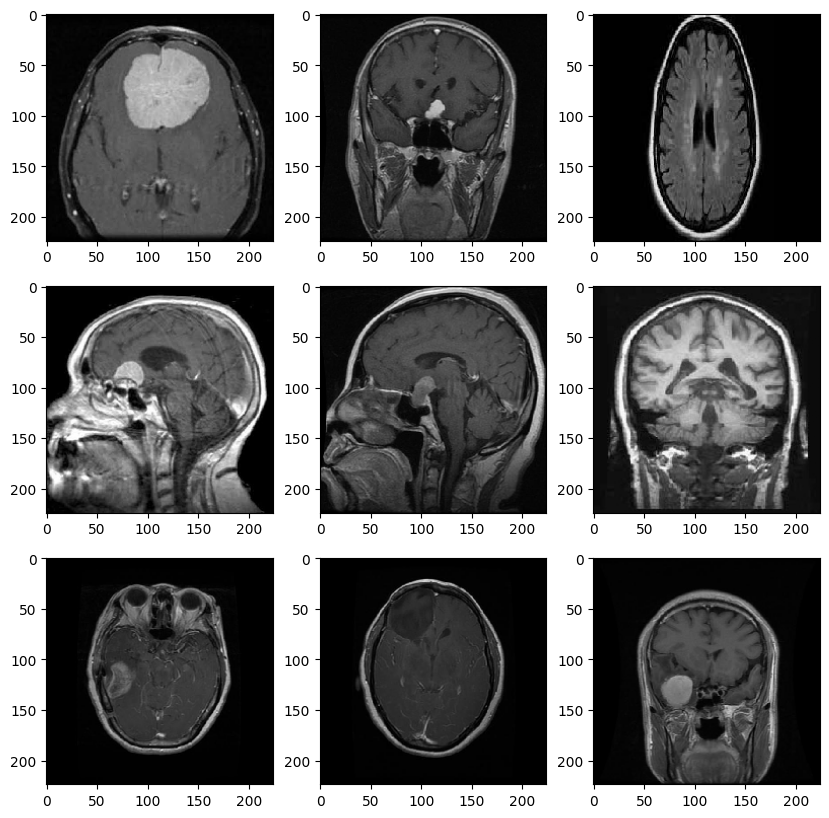

In [51]:
# Rescale and split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Print class indices and number of images
print(train_generator.class_indices)
print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")

# Visualize some augmented images
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = images[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
plt.show()

## Data Augmentation
*The Data Augmentation process will only be applied onto the training dataset, as the purpose of augmentation is to introduce variations to the training data to improve the model's generalization*

Found 336 images belonging to 4 classes.


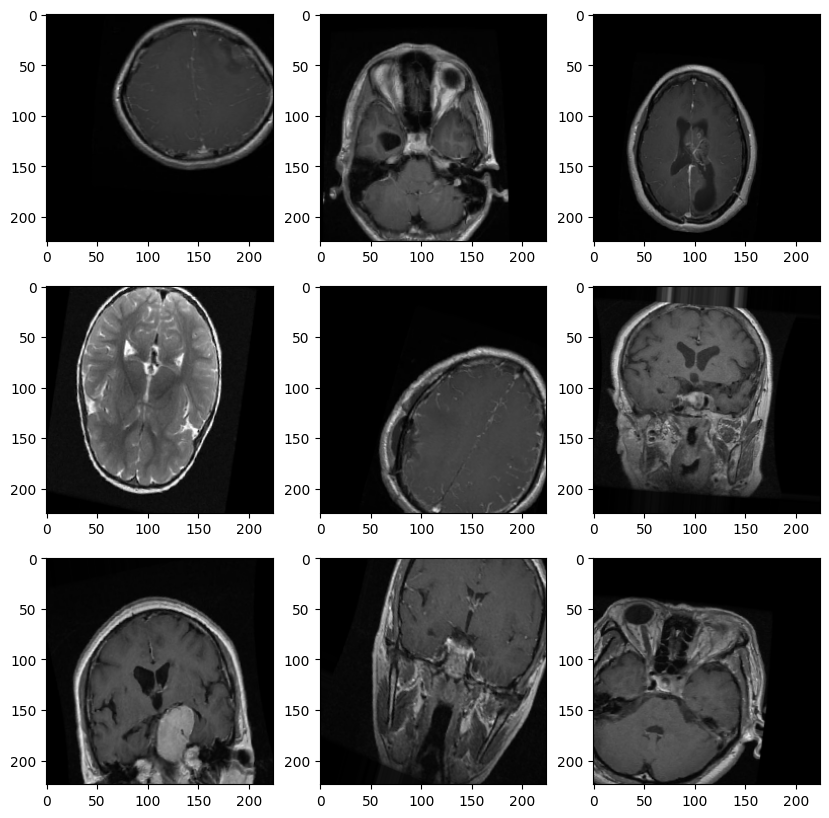

In [52]:
# Data augmentation on the training dataset
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen_augmented.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Visualize some augmented images
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = images[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
plt.show()

# 3. Model Building - ResNet50V2
*Improved Version of ResNet50v2*

In [53]:
# Load ResNet50V2 base model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create and compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,667,076 (97.91 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4863 - loss: 1.6020 - val_accuracy: 0.7222 - val_loss: 0.8878
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 933ms/step - accuracy: 0.7633 - loss: 0.6201 - val_accuracy: 0.6319 - val_loss: 1.3974
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 957ms/step - accuracy: 0.8078 - loss: 0.4430 - val_accuracy: 0.7569 - val_loss: 0.7423
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 922ms/step - accuracy: 0.9343 - loss: 0.2278 - val_accuracy: 0.7917 - val_loss: 0.5968
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 928ms/step - accuracy: 0.9051 - loss: 0.2458 - val_accuracy: 0.7569 - val_loss: 0.7037
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 920ms/step - accuracy: 0.9298 - loss: 0.2063 - val_accuracy: 0.7778 - val_loss: 0.7241
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 922ms/step - accuracy: 0.9151 - loss: 0.2191 - val_accuracy: 0.7778 - val_loss: 0.6129
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 926ms/step - accuracy: 0.9460 - loss: 0.1813 - val_accurac

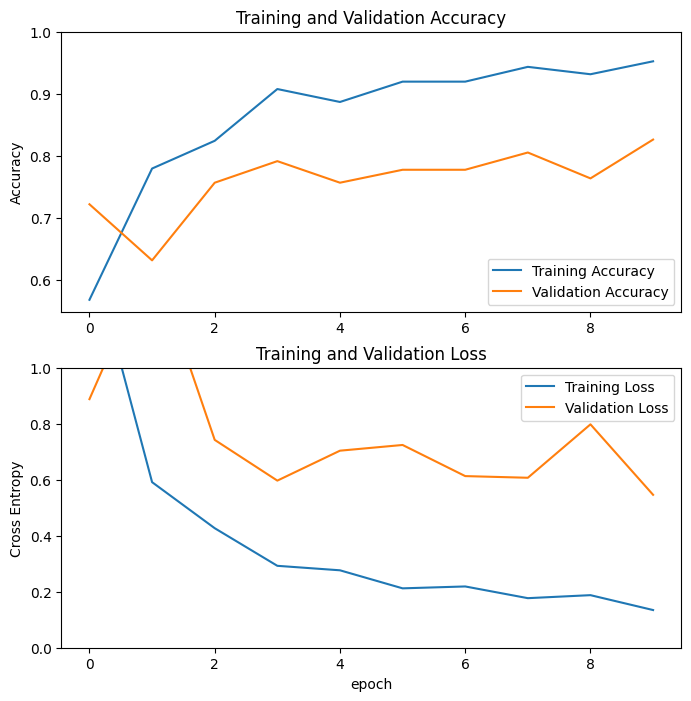

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 572ms/step - accuracy: 0.8137 - loss: 0.5870
Test Accuracy : 0.8263888955116272
Test Loss : 0.5461026430130005
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.8605 - loss: 0.4170
Validation Accuracy: 0.83


In [54]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)


# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')

## Base Model Performance Evaluation
In our initial training phase, we observed the following indicators of overfitting:
* The training accuracy quickly reached 100%, while the validation accuracy plateaued around 80%.
* The validation loss did not consistently decrease, indicating that the model is not generalizing well to the validation data.

Therefore, to address such overfitting issues, optimization techniques such as Dropout, Regularization, and Early Stopping have to be employed.

Explanation of each Techniques: 
1. Dropout: 
    * Dropout helps prevent overfitting by randomly setting a fraction of input units to zero during training.
2. L2 Regularization: 
    * L2 regularization adds a penalty to the loss function proportional to the square of the weights, discouraging large weights.
3. Early Stopping
    * Early stopping monitors the model's performance on the validation set and stops training when the performance starts to degrade.




## Base Model's Top Layer Optimisation

In [55]:
# Freeze the base model layers
base_model.trainable = False

# Add custom top layers with Dropout and L2 Regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding Dropout layer
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Adding L2 Regularization
output = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with frozen base layers and added regularization
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,667,076 (97.91 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4260 - loss: 14.5326 - val_accuracy: 0.6597 - val_loss: 11.0980
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 921ms/step - accuracy: 0.6926 - loss: 10.0749 - val_accuracy: 0.6736 - val_loss: 8.5444
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 942ms/step - accuracy: 0.7583 - loss: 7.6323 - val_accuracy: 0.7431 - val_loss: 6.4440
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 971ms/step - accuracy: 0.7590 - loss: 6.2358 - val_accuracy: 0.7500 - val_loss: 5.4466
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8005 - loss: 5.1443 - val_accuracy: 0.7153 - val_loss: 4.7297
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 989ms/step - accuracy: 0.7903 - loss: 4.3961 - val_accuracy: 0.7639 - val_loss: 4.1455
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 982ms/step - accuracy: 0.8639 - loss: 3.7823 - val_accuracy: 0.7500 - val_loss: 3.7155
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 969ms/step - accuracy: 0.8431 - loss: 3.3706 - val_accurac

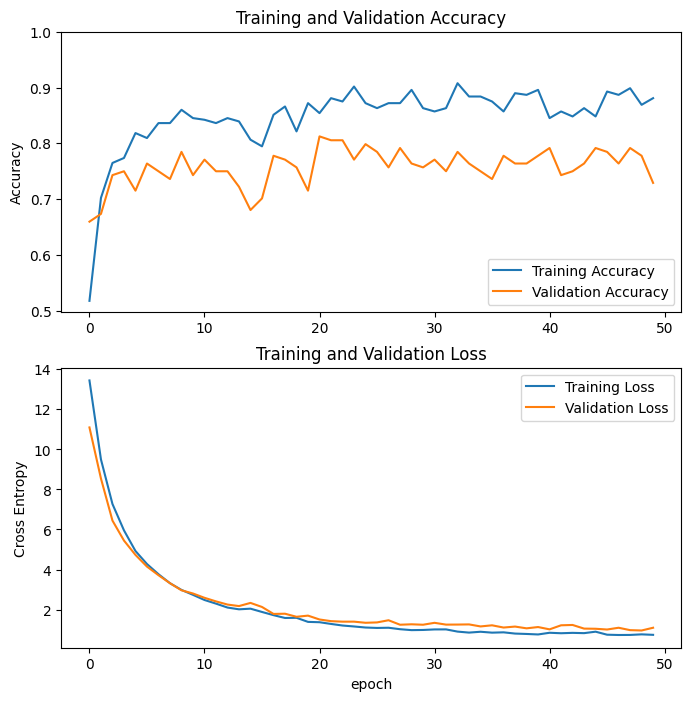

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.7350 - loss: 1.0855
Test Accuracy : 0.7777777910232544
Test Loss : 0.9533410668373108
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.7853 - loss: 0.9580
Validation Accuracy: 0.78


In [56]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)


# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')

### Fine-Tuning the Model
After optimizing the top layers with the frozen base model, we can unfreeze some of the layers in the base model to fine-tune the entire network. This step can potentially improve performance by allowing more flexibility in adapting the pre-trained features to our specific dataset.


In [57]:
# Unfreeze some layers in the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = False

# Recompile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9086 - loss: 0.6649 - val_accuracy: 0.7708 - val_loss: 1.0235
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 929ms/step - accuracy: 0.9026 - loss: 0.6286 - val_accuracy: 0.7778 - val_loss: 0.9678
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 922ms/step - accuracy: 0.8983 - loss: 0.6186 - val_accuracy: 0.7986 - val_loss: 0.8926
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 924ms/step - accuracy: 0.9149 - loss: 0.5744 - val_accuracy: 0.7917 - val_loss: 0.8871
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 924ms/step - accuracy: 0.9166 - loss: 0.5945 - val_accuracy: 0.7847 - val_loss: 0.8937
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 986ms/step - accuracy: 0.9000 - loss: 0.5893 - val_accuracy: 0.7847 - val_loss: 0.8882
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 985ms/step - accuracy: 0.8880 - loss: 0.5633 - val_accuracy: 0.7778 - val_loss: 0.8565
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 967ms/step - accuracy: 0.9248 - loss: 0.5391 - val_accurac

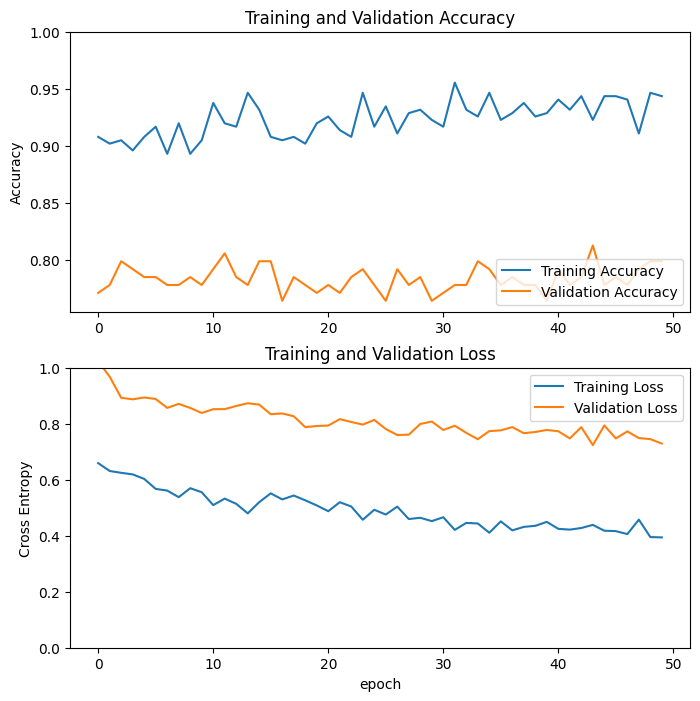

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - accuracy: 0.8060 - loss: 0.7208
Test Accuracy: 0.81
Test Loss: 0.72
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 572ms/step - accuracy: 0.8220 - loss: 0.7120
Validation Accuracy: 0.81


In [58]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Test Loss: {loss:.2f}')

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')

# Hyper Params Optimisation

In [61]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Tuning the number of dense layers and units
    for i in range(hp.Int('num_dense_layers', 1, 5)):
        x = Dense(units=hp.Int('units_' + str(i), min_value=64, max_value=1024, step=64),
                  activation=hp.Choice('dense_activation_' + str(i), ['relu', 'tanh', 'sigmoid']))(x)
        
        if hp.Choice('use_batch_norm_' + str(i), ['yes', 'no']) == 'yes':
            x = BatchNormalization()(x)
        
        if hp.Choice('use_dropout_' + str(i), ['yes', 'no']) == 'yes':
            x = Dropout(rate=hp.Float('dropout_' + str(i), 0.2, 0.5, step=0.1))(x)
    
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Define tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter-search',
    project_name='brain-tumor-classification'
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Running the tuner search
tuner.search(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])

# Getting the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
Best hyperparameters:
- Number of dense layers: {best_hp.get('num_dense_layers')}
- Dense units and activations:
""")
for i in range(best_hp.get('num_dense_layers')):
    print(f"  Layer {i + 1}: {best_hp.get('units_' + str(i))} units, activation {best_hp.get('dense_activation_' + str(i))}")
    print(f"    Use batch normalization: {best_hp.get('use_batch_norm_' + str(i))}")
    print(f"    Use dropout: {best_hp.get('use_dropout_' + str(i))}")
    if best_hp.get('use_dropout_' + str(i)) == 'yes':
        print(f"    Dropout rate: {best_hp.get('dropout_' + str(i))}")
print(f"""- Learning rate: {best_hp.get('learning_rate')}""")


Trial 30 Complete [00h 04m 22s]
val_accuracy: 0.7986111044883728

Best val_accuracy So Far: 0.8125
Total elapsed time: 00h 48m 43s

Best hyperparameters:
- Number of dense layers: 3
- Dense units and activations:

  Layer 1: 576 units, activation sigmoid
    Use batch normalization: yes
    Use dropout: yes
    Dropout rate: 0.30000000000000004
  Layer 2: 704 units, activation tanh
    Use batch normalization: no
    Use dropout: yes
    Dropout rate: 0.30000000000000004
  Layer 3: 640 units, activation relu
    Use batch normalization: no
    Use dropout: yes
    Dropout rate: 0.2
- Learning rate: 0.00027398244095838686


In [62]:
# Build the best model
best_model = tuner.hypermodel.build(best_hp)

# Train the best model
history = best_model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3839 - loss: 1.3428 - val_accuracy: 0.5694 - val_loss: 1.1599
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 998ms/step - accuracy: 0.7440 - loss: 0.6372 - val_accuracy: 0.6250 - val_loss: 1.0283
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 952ms/step - accuracy: 0.8041 - loss: 0.5234 - val_accuracy: 0.6111 - val_loss: 0.9662
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 972ms/step - accuracy: 0.8452 - loss: 0.4350 - val_accuracy: 0.6528 - val_loss: 0.9190
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 958ms/step - accuracy: 0.8639 - loss: 0.3637 - val_accuracy: 0.6667 - val_loss: 0.8821
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8896 - loss: 0.2944 - val_accuracy: 0.6458 - val_loss: 0.8477
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8625 - loss: 0.3030 - val_accuracy: 0.7153 - val_loss: 0.7732
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9226 - loss: 0.2000 - val_accuracy: 0.7292

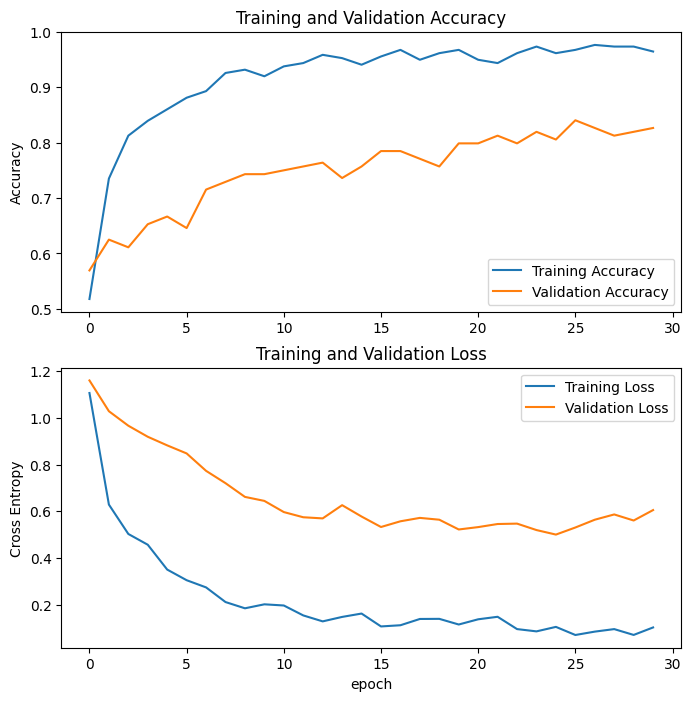

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - accuracy: 0.8168 - loss: 0.7103
Test Accuracy : 0.8125
Test Loss : 0.7234596610069275
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.8264 - loss: 0.6924
Validation Accuracy: 0.81


In [63]:
""" Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')

## Optimal Epochs Determination -dk to add anot

In [69]:
#Find Out Best Number Epoch
model = tuner.hypermodel.build(best_hp)
history = model.fit(train_generator, epochs=50, validation_data=validation_generator)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4397 - loss: 1.2657 - val_accuracy: 0.4583 - val_loss: 1.1530
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 985ms/step - accuracy: 0.7651 - loss: 0.5551 - val_accuracy: 0.5625 - val_loss: 1.0576
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 985ms/step - accuracy: 0.7995 - loss: 0.4572 - val_accuracy: 0.6111 - val_loss: 0.9542
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8460 - loss: 0.4107 - val_accuracy: 0.7083 - val_loss: 0.8472
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9133 - loss: 0.3165 - val_accuracy: 0.7292 - val_loss: 0.7914
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8562 - loss: 0.3386 - val_accuracy: 0.7431 - val_loss: 0.7402
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9051 - loss: 0.2574 - val_accuracy: 0.7500 - val_loss: 0.6778
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 999ms/step - accuracy: 0.9301 - loss: 0.2150 - val_accuracy: 0.7292 - 

Epoch 1/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3951 - loss: 1.3175 - val_accuracy: 0.5417 - val_loss: 1.1247
Epoch 2/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 963ms/step - accuracy: 0.7256 - loss: 0.6225 - val_accuracy: 0.5556 - val_loss: 1.0222
Epoch 3/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 995ms/step - accuracy: 0.8589 - loss: 0.4643 - val_accuracy: 0.4931 - val_loss: 0.9871
Epoch 4/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8613 - loss: 0.3320 - val_accuracy: 0.5347 - val_loss: 0.9508
Epoch 5/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 948ms/step - accuracy: 0.8658 - loss: 0.3355 - val_accuracy: 0.6736 - val_loss: 0.8386
Epoch 6/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 934ms/step - accuracy: 0.9216 - loss: 0.2605 - val_accuracy: 0.7083 - val_loss: 0.7770
Epoch 7/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 941ms/step - accuracy: 0.8811 - loss: 0.2731 - val_accuracy: 0.7222 - val_loss: 0.7425
Epoch 8/26
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 931ms/step - accuracy: 0.9142 - loss: 0.2473 - val_accuracy: 

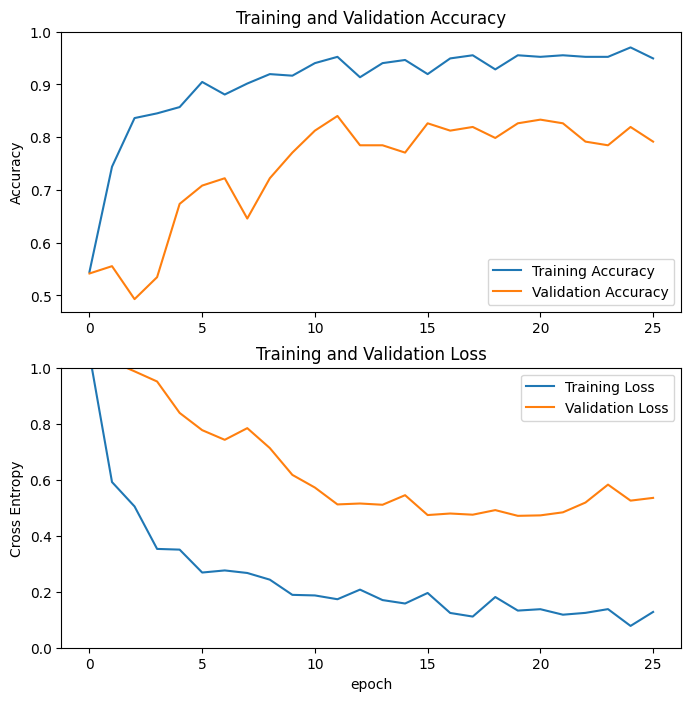

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.7989 - loss: 0.7422
Test Accuracy : 0.8055555820465088
Test Loss : 0.736248791217804
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.7980 - loss: 0.7605
Validation Accuracy: 0.81
Model saved to ./models/resnet50_model.keras


In [70]:
# Train the best model for the optimal number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(train_generator, epochs=best_epoch, validation_data=validation_generator, callbacks=[early_stopping])

val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy:.4f}')

""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')

# Save the final model
model.save(MODEL_FILE)
print(f"Model saved to {MODEL_FILE}")